# Reinforcement learning
### Snake - Temporal difference
SARSA algorithm

In [20]:
from snake import Game
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML, Image

### Setup

In [21]:
# modified dictionary that incorporates random defaults and epsilon greedy
class Policy(dict):
    
    import random
    
    def __init__(self,actions,epsilon=0.1):
        '''
        A policy with built in epsilon greedy and a uniform random choice for non initialized keys 
        actions - list of all possible actions
        epsilon - chance for explore
        '''
        self.actions = actions
        self.eps = epsilon
        super().__init__(self)
        
    def __getitem__(self, key):
        c = random.random()
        if (c<self.eps or key not in self):
            return self.actions[random.randint(0,len(self.actions)-1)]
        else:
            return super().__getitem__(key)
        
    def update_with_Q(self,s,qs):
        '''Update policy for a state given the Q values for this state and all available actions'''
        # update policy for this state
        a = np.argmax([i[1] for i in qs.items()])
        self[s] = [i[0] for i in qs.items()][a]
        

In [22]:
# game parameters
grid = 8
s_size = 3
# start game
game = Game(grid, s_size)
game.reset()

# discount factor
g = 0.9
# learning rate
learning_rate = 0.1

# initialize policy
policy = Policy([0,1,2,3])

# dummy state for a lost game
LOSS = tuple(np.ones(6)*-1)

### Learning

In [23]:
# Q values
Q = {}
Q[LOSS] = {}
Q[LOSS][0] = 0
# state/action counts (for decaying learning rate)
counts = {}

# run MC loop
for i in range(10000):
    # reset some variables
    s = tuple(game.get_state())
    r = 0
    a = policy[s]
    score = 0
    turns = 0
    # play one episode
    while (True):
        # count turns (success in terms of not dying)
        turns+=1
        # count score
        if (game.score>score):
            score = game.score
        # apply action
        game.snake.d = a
        # run one game step, get reward and check if episode is finished
        r,e = game.iterate()
        # decaying learning rate
        if (s not in counts):
            counts[s] = {}
        if (a not in counts[s]):
            counts[s][a] = 0
        counts[s][a]+=1
        lr = learning_rate/(1+counts[s][a]//10)
        # add default Q if missing
        if (s not in Q):
            Q[s] = {}
        if (a not in Q[s]):
            Q[s][a] = 0
        # treat specific cases
        if (e==-1):
            # game is lost, update with final dummy state
            Q[s][a] = Q[s][a] + lr*(r + g*Q[LOSS][0] - Q[s][a])
            policy.update_with_Q(s,Q[s])
            # start a new episode
            break
        elif (e==1):
            # eat apple, update modified state
            eat = np.array(s)
            eat[-2:] = 0
            if (tuple(eat) not in Q):
                Q[tuple(eat)] = {}
                Q[tuple(eat)][0] = 0
            Q[s][a] = Q[s][a] + lr*(r + g*Q[tuple(eat)][0] - Q[s][a])
            policy.update_with_Q(s,Q[s])
            r = 0
            s = tuple(game.get_state())
            a = policy[s]
        else:
            # next state and next action
            s_p = tuple(game.get_state())
            a_p = policy[s_p]
            # update Q
            if (s_p not in Q):
                Q[s_p] = {}
            if (a_p not in Q[s_p]):
                Q[s_p][a_p] = 0
            Q[s][a] = Q[s][a] + lr*(r + g*Q[s_p][a_p] - Q[s][a])
            # update policy for this state
            policy.update_with_Q(s,Q[s])
            # update variables for next iteration
            s = s_p
            a = a_p           
    # print progress
    if (i%1000==0):
        print(i,turns,score)

0 2 0
1000 54 6
2000 24 5
3000 54 9
4000 11 0
5000 15 2
6000 2 0
7000 5 1
8000 43 5
9000 9 1


### Animation

In [24]:
# extract the policy without epsilon greedy
p = dict(policy)

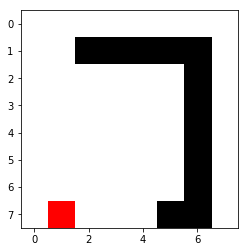

In [25]:
# render a game animation
fig, ax = plt.subplots()
image = ax.imshow(game.board)

g = Game(grid, s_size)
g.reset()

def init():
    image.set_data(g.board)
    return (image,)

def animate(i):
    s = g.get_state()
    a = p[tuple(s)]
    g.snake.d = a
    g.iterate() 
    g.draw()
    image.set_data(g.board)
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=120, 
                               blit=True)

anim.save('./animations/sarsa.gif', writer='imagemagick', fps=30)

### Result

In [26]:
Image(url='./animations/sarsa.gif')